# 課題
* solubilityデータセットの、上で作った検証データに対して、できるだけ予測性能の良いモデルを見つけよう
  * Ridge回帰やLassoを使ってもいいです。
  * 特徴量はどのように加工してもいいです。（上では2値変数にPCAを使った。）
* 検証データを使って見つけた最も良いモデルを、最後に一回、テストデータで評価してみよう

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina'

RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

In [2]:
PATH = './data/'

X = pd.read_csv(PATH + 'solTrainX.csv')
y = pd.read_csv(PATH + 'solTrainY.csv')['x']

X_test = pd.read_csv(PATH + 'solTestX.csv')
y_test = pd.read_csv(PATH + 'solTestY.csv')['x']

In [3]:
continuous = [s for s in X.columns if s[:3] in ['Num', 'Hyd', 'Mol', 'Sur']]
print(len(continuous), 'continuous features')
print(continuous)

20 continuous features
['MolWeight', 'NumAtoms', 'NumNonHAtoms', 'NumBonds', 'NumNonHBonds', 'NumMultBonds', 'NumRotBonds', 'NumDblBonds', 'NumAromaticBonds', 'NumHydrogen', 'NumCarbon', 'NumNitrogen', 'NumOxygen', 'NumSulfer', 'NumChlorine', 'NumHalogen', 'NumRings', 'HydrophilicFactor', 'SurfaceArea1', 'SurfaceArea2']


In [4]:
binary = X.columns[X.columns.str.startswith('FP')]
print(len(binary), 'binary features')

208 binary features


## EDA

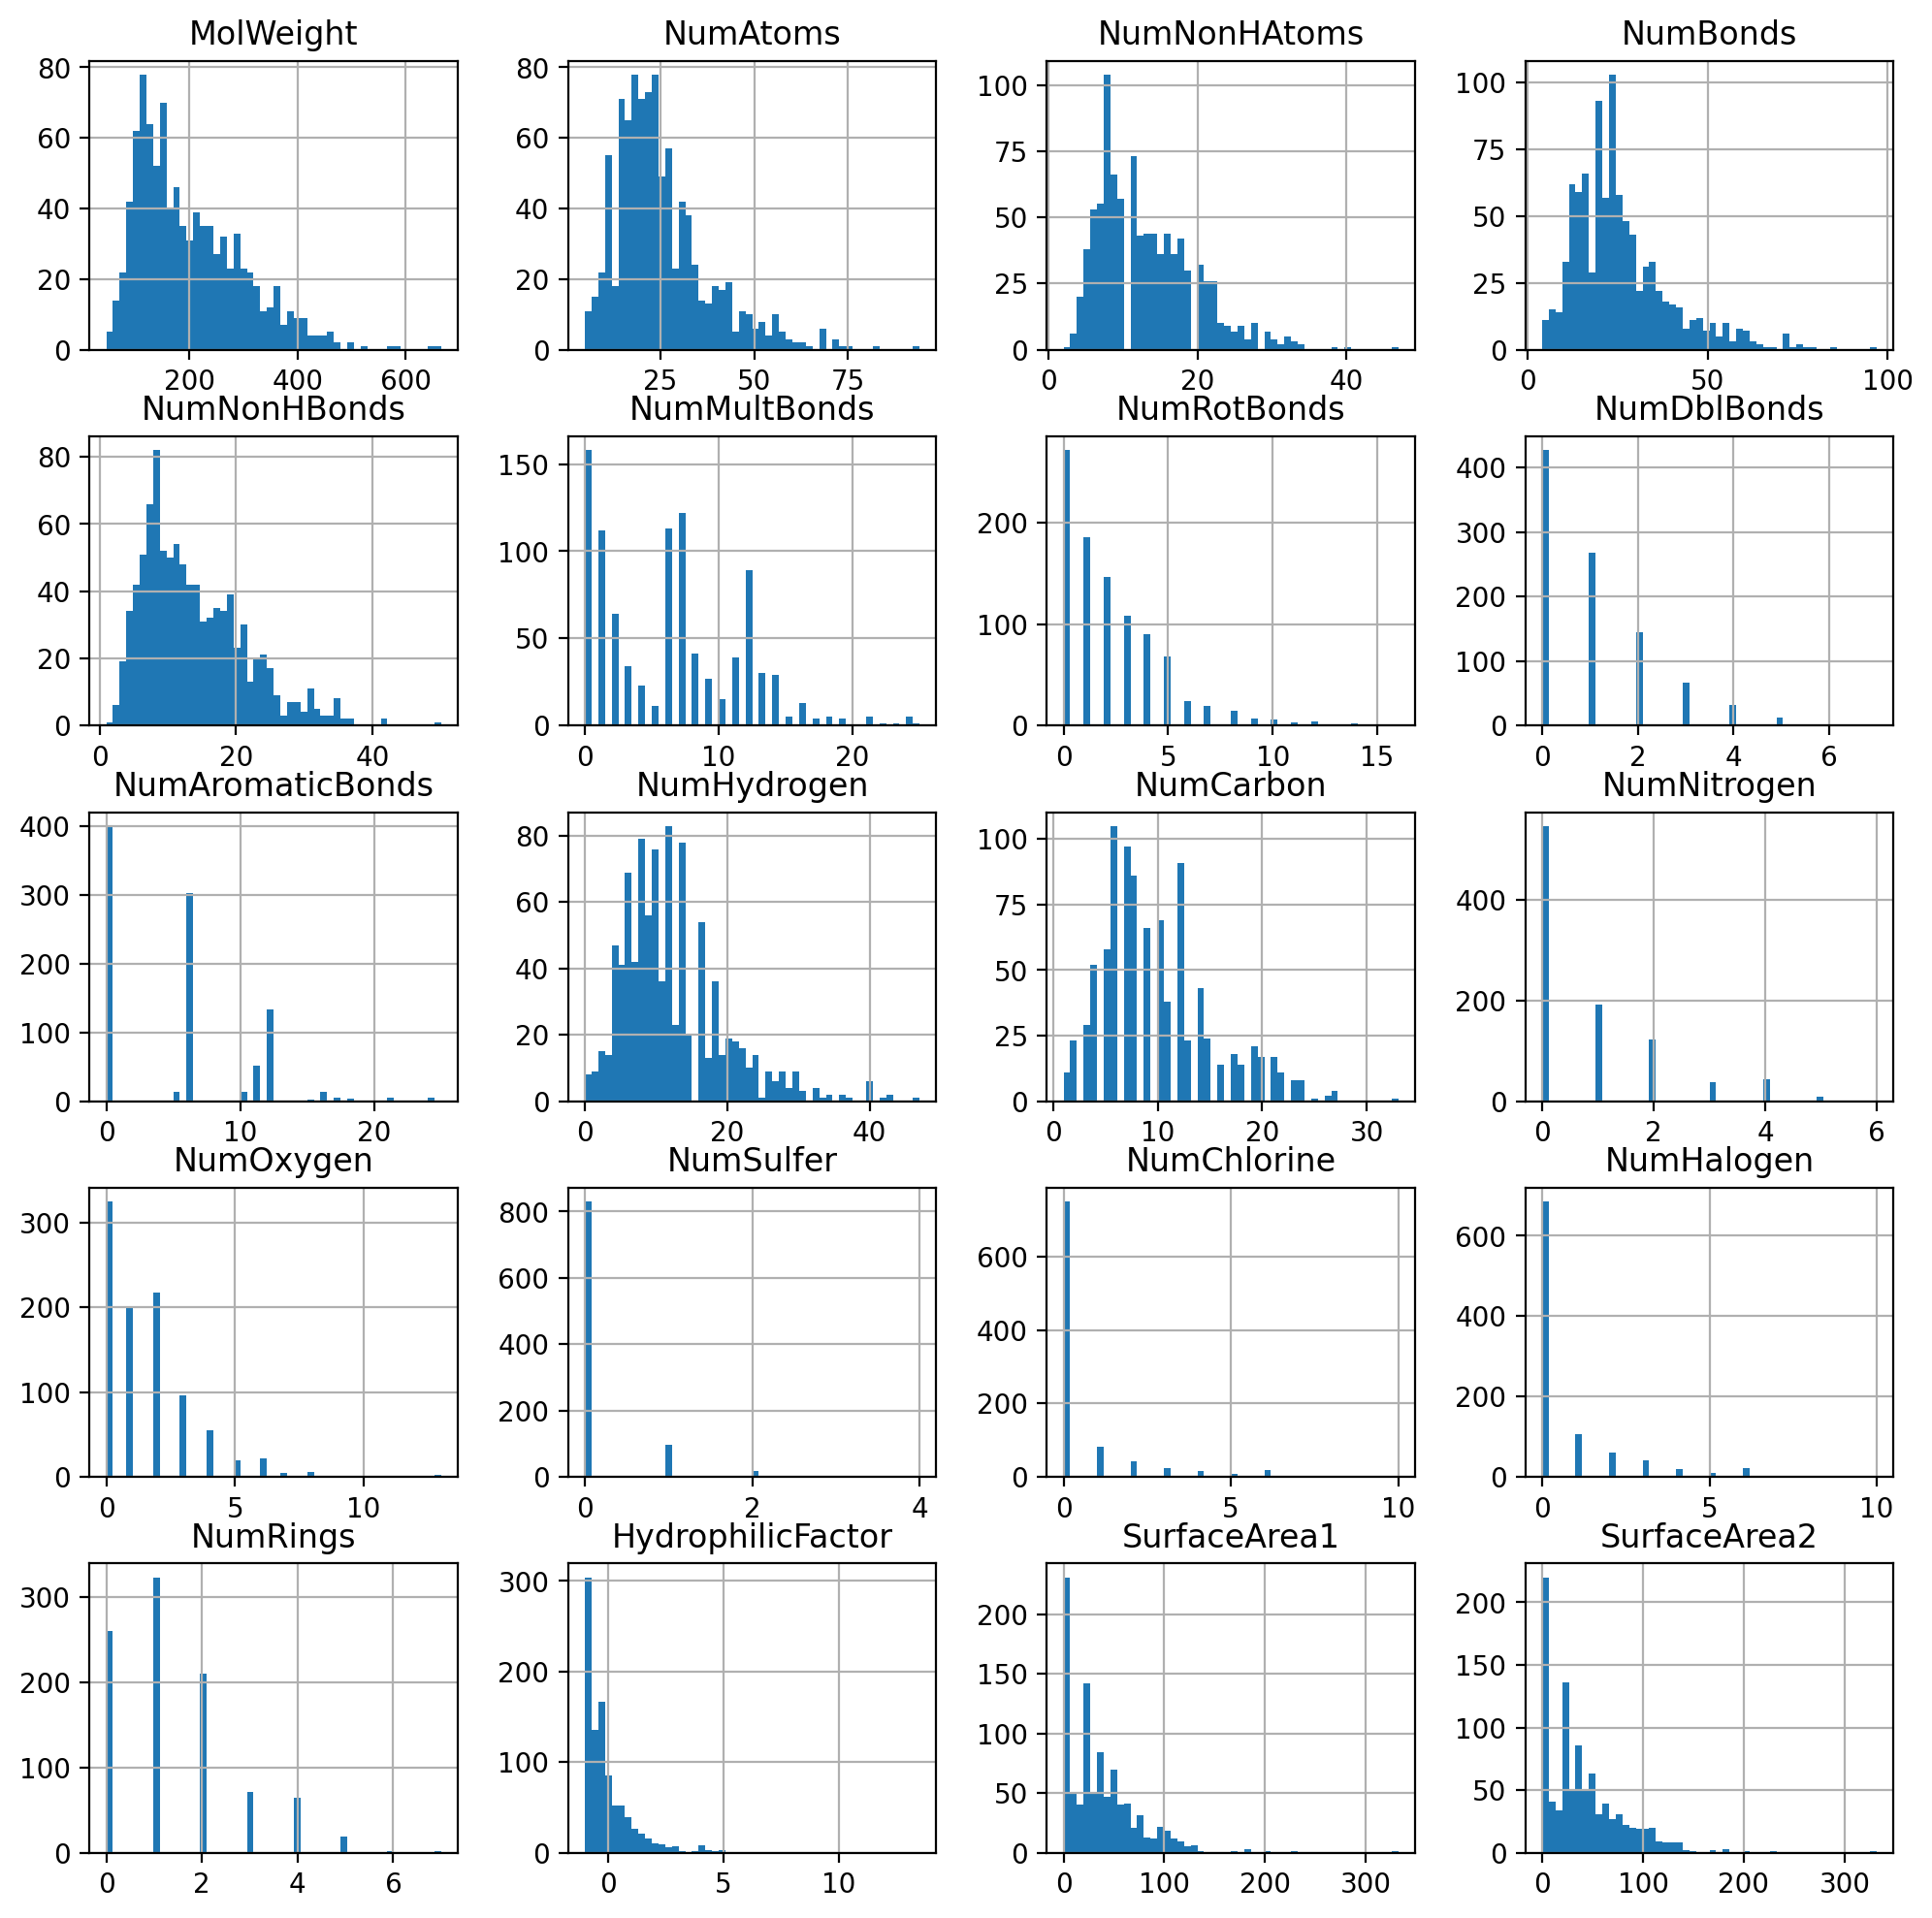

In [5]:
X[continuous].hist(bins=50, figsize=(12, 12));

* 最小値の頻度が突出して高いfeatureがいくつかある。

In [6]:
for feature in ['SurfaceArea1', 'SurfaceArea2', 'NumNitrogen', 'NumSulfer', 'NumChlorine', 'NumHalogen']:
    print(feature, (X[feature].min() == X[feature]).sum())

SurfaceArea1 218
SurfaceArea2 211
NumNitrogen 546
NumSulfer 830
NumChlorine 750
NumHalogen 685


* 新たなbinary featureを追加する。
  * 最小値を取るときは1、そうでなければ0。

In [7]:
for feature in ['SurfaceArea1', 'SurfaceArea2', 'NumNitrogen', 'NumSulfer', 'NumChlorine', 'NumHalogen']:
    X_min = X[feature].min()
    X[f"FP_{feature}"] = (X_min == X[feature]) * 1
    X_test[f"FP_{feature}"] = (X_min == X_test[feature]) * 1

In [8]:
binary = X.columns[X.columns.str.startswith('FP')]
print(len(binary), 'binary features')

214 binary features


## 交差検証の準備

In [9]:
kfold_splits = []
for _ in range(3):
  kfold_splits.append(list(
      KFold(n_splits=10, shuffle=True, random_state=np.random.randint(100)).split(X)
  ))

## Ridge回帰

In [10]:
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
scaler = MinMaxScaler()

best_rmse = float('inf')
best_n_components = None
best_alpha = None
for n_components in 0.91 + 0.02 * np.arange(5):
  pca = PCA(n_components=n_components, random_state=RANDOM_STATE)

  for alpha in 10.0 ** np.arange(-5, 0):
    reg = Ridge(alpha=alpha, random_state=RANDOM_STATE)

    rmse = []
    for kfold_split in kfold_splits:
      for train_index, val_index in kfold_split:
        X_train, y_train = X.iloc[train_index], y[train_index]
        X_valid, y_valid = X.iloc[val_index], y[val_index]

        X_train_binary = pca.fit_transform(poly.fit_transform(X_train[binary]))
        X_train_continuous = scaler.fit_transform(X_train[continuous])
        X_train_embedded = np.concatenate([X_train_binary, X_train_continuous], 1)

        X_valid_binary = pca.transform(poly.transform(X_valid[binary]))
        X_valid_continuous = scaler.transform(X_valid[continuous])
        X_valid_embedded = np.concatenate([X_valid_binary, X_valid_continuous], 1)

        reg.fit(X_train_embedded, y_train)
        y_valid_pred = reg.predict(X_valid_embedded)
        rmse.append(mean_squared_error(y_valid, y_valid_pred, squared=False))

    rmse = np.array(rmse)
    print(f"PCA {n_components:.2f} | alpha {alpha:.1e} | ", end="")
    print(f"max RMSE {rmse.max():.3f} | avg RMSE {rmse.mean():.3f}")
    if rmse.mean() < best_rmse:
      best_rmse = rmse.mean()
      best_n_components = n_components
      best_alpha = alpha

  print('-'*40)
print(f"best rmse {best_rmse:.3f} | ", end="")
print(f"n_components={best_n_components:.2f} | alpha={best_alpha}")

PCA 0.91 | alpha 1.0e-05 | max RMSE 0.745 | avg RMSE 0.601
PCA 0.91 | alpha 1.0e-04 | max RMSE 0.744 | avg RMSE 0.601
PCA 0.91 | alpha 1.0e-03 | max RMSE 0.740 | avg RMSE 0.599
PCA 0.91 | alpha 1.0e-02 | max RMSE 0.733 | avg RMSE 0.597
PCA 0.91 | alpha 1.0e-01 | max RMSE 0.721 | avg RMSE 0.602
----------------------------------------
PCA 0.93 | alpha 1.0e-05 | max RMSE 0.781 | avg RMSE 0.597
PCA 0.93 | alpha 1.0e-04 | max RMSE 0.780 | avg RMSE 0.597
PCA 0.93 | alpha 1.0e-03 | max RMSE 0.773 | avg RMSE 0.595
PCA 0.93 | alpha 1.0e-02 | max RMSE 0.761 | avg RMSE 0.594
PCA 0.93 | alpha 1.0e-01 | max RMSE 0.750 | avg RMSE 0.601
----------------------------------------
PCA 0.95 | alpha 1.0e-05 | max RMSE 0.768 | avg RMSE 0.589
PCA 0.95 | alpha 1.0e-04 | max RMSE 0.766 | avg RMSE 0.588
PCA 0.95 | alpha 1.0e-03 | max RMSE 0.755 | avg RMSE 0.586
PCA 0.95 | alpha 1.0e-02 | max RMSE 0.736 | avg RMSE 0.585
PCA 0.95 | alpha 1.0e-01 | max RMSE 0.722 | avg RMSE 0.591
---------------------------------

## テストセットで評価

In [11]:
n_components = best_n_components
alpha = best_alpha

pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
reg = Ridge(alpha=alpha, random_state=RANDOM_STATE)

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
scaler = MinMaxScaler()

X_binary = pca.fit_transform(poly.fit_transform(X[binary]))
X_continuous = scaler.fit_transform(X[continuous])
X_embedded = np.concatenate([X_binary, X_continuous], 1)
X_test_binary = pca.transform(poly.transform(X_test[binary]))
X_test_continuous = scaler.transform(X_test[continuous])
X_test_embedded = np.concatenate([X_test_binary, X_test_continuous], 1)

reg.fit(X_embedded, y)
y_test_pred = reg.predict(X_test_embedded)
print(f'test RMSE {mean_squared_error(y_test, y_test_pred, squared=False):.4f}')

test RMSE 0.6577
